In [1]:
# Required imports
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
import sentence_transformers
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Fetch the dataset
online_retail = fetch_ucirepo(id=352)

# Create full dataframe
X = pd.concat([online_retail.data.ids, online_retail.data.features], axis=1)
X.head()

c:\Users\User\x-med\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [2]:
# Check for missing values and clean the data
def preprocess_data(df):
    # Make a copy to avoid modifying the original
    df_clean = df.copy()
    
    # Check for missing values
    print("Missing values per column:")
    print(df_clean.isnull().sum())
    
    # Remove rows with missing product descriptions
    df_clean = df_clean.dropna(subset=['Description'])
    
    # Filter out canceled invoices (invoices starting with 'C')
    df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]
    
    # Convert invoice date to datetime
    df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
    
    # Filter out entries with non-positive quantities or prices
    df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]
    
    return df_clean

# Apply preprocessing
X_clean = preprocess_data(X)
print(f"After cleaning, dataset shape: {X_clean.shape}")

Missing values per column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
After cleaning, dataset shape: (530104, 8)


In [3]:
def get_top_countries(df, n=5):
    # Count transactions by country
    country_counts = df.groupby('Country').size().reset_index(name='counts')
    country_counts = country_counts.sort_values('counts', ascending=False)
    
    top_n_countries = country_counts.head(n)['Country'].tolist()
    
    print(f"Top {n} countries by transaction count:")
    for i, (country, count) in enumerate(zip(country_counts.head(n)['Country'], 
                                           country_counts.head(n)['counts']), 1):
        print(f"{i}. {country}: {count:,} transactions")
    
    return top_n_countries

# Get top 5 countries
top_countries = get_top_countries(X_clean)

Top 5 countries by transaction count:
1. United Kingdom: 485,123 transactions
2. Germany: 9,040 transactions
3. France: 8,407 transactions
4. EIRE: 7,890 transactions
5. Spain: 2,484 transactions


In [4]:
# Filter data to include only top countries
X_filtered = X_clean[X_clean['Country'].isin(top_countries)].copy()
print(f"Filtered dataset shape (top countries only): {X_filtered.shape}")

# Cell 4: Prepare Product Descriptions for Embedding
# Extract unique product descriptions
unique_products = X_filtered[['StockCode', 'Description']].drop_duplicates()
print(f"Number of unique products: {len(unique_products)}")

# If dataset is very large, sample a subset for visualization
max_products = 5000
if len(unique_products) > max_products:
    # Set random seed for reproducibility
    np.random.seed(42)
    unique_products = unique_products.sample(max_products)
    print(f"Sampled {max_products} products for visualization")

# Get descriptions and codes
descriptions = unique_products['Description'].tolist()
stock_codes = unique_products['StockCode'].tolist()

Filtered dataset shape (top countries only): (512944, 8)
Number of unique products: 4153


In [9]:
from sentence_transformers import SentenceTransformer

def create_embeddings(texts, model_name='all-MiniLM-L6-v2'):
    """
    Create embeddings using a small Sentence Transformer model
    that can run efficiently on CPU
    """
    print(f"Loading model: {model_name}")
    model = SentenceTransformer(model_name)
    
    print("Creating embeddings...")
    embeddings = model.encode(texts, show_progress_bar=True)
    print(f"Embeddings created with shape: {embeddings.shape}")
    
    return embeddings

# Create embeddings for product descriptions
embeddings = create_embeddings(descriptions)

Loading model: all-MiniLM-L6-v2
Creating embeddings...


Batches: 100%|██████████| 130/130 [00:07<00:00, 16.46it/s]

Embeddings created with shape: (4153, 384)


In [11]:
from sklearn.manifold import TSNE

def apply_tsne(embeddings, perplexity=30, n_components=2):
    """
    Apply t-SNE dimensionality reduction
    """
    print("Applying t-SNE...")
    tsne = TSNE(n_components=n_components, 
                perplexity=perplexity, 
                n_iter=1000, 
                random_state=42)
    
    reduced_embeddings = tsne.fit_transform(embeddings)
    print(f"t-SNE reduced embeddings shape: {reduced_embeddings.shape}")
    
    return reduced_embeddings

# Apply t-SNE
tsne_embeddings = apply_tsne(embeddings)

Applying t-SNE...
t-SNE reduced embeddings shape: (4153, 2)


In [14]:
from collections import Counter

def map_products_to_countries(df, stock_codes):
    """
    Create a mapping from stock codes to most common country for that product
    """
    product_country_map = {}
    
    for code in stock_codes:
        # Find all countries where this product was sold
        countries = df[df['StockCode'] == code]['Country'].tolist()
        
        if countries:
            # Get the most common country
            most_common = Counter(countries).most_common(1)[0][0]
            product_country_map[code] = most_common
    
    return product_country_map

# Map products to countries
product_country_map = map_products_to_countries(X_filtered, stock_codes)

# Create a list of countries for each product in our sampled dataset
countries = [product_country_map.get(code, 'Unknown') for code in stock_codes]

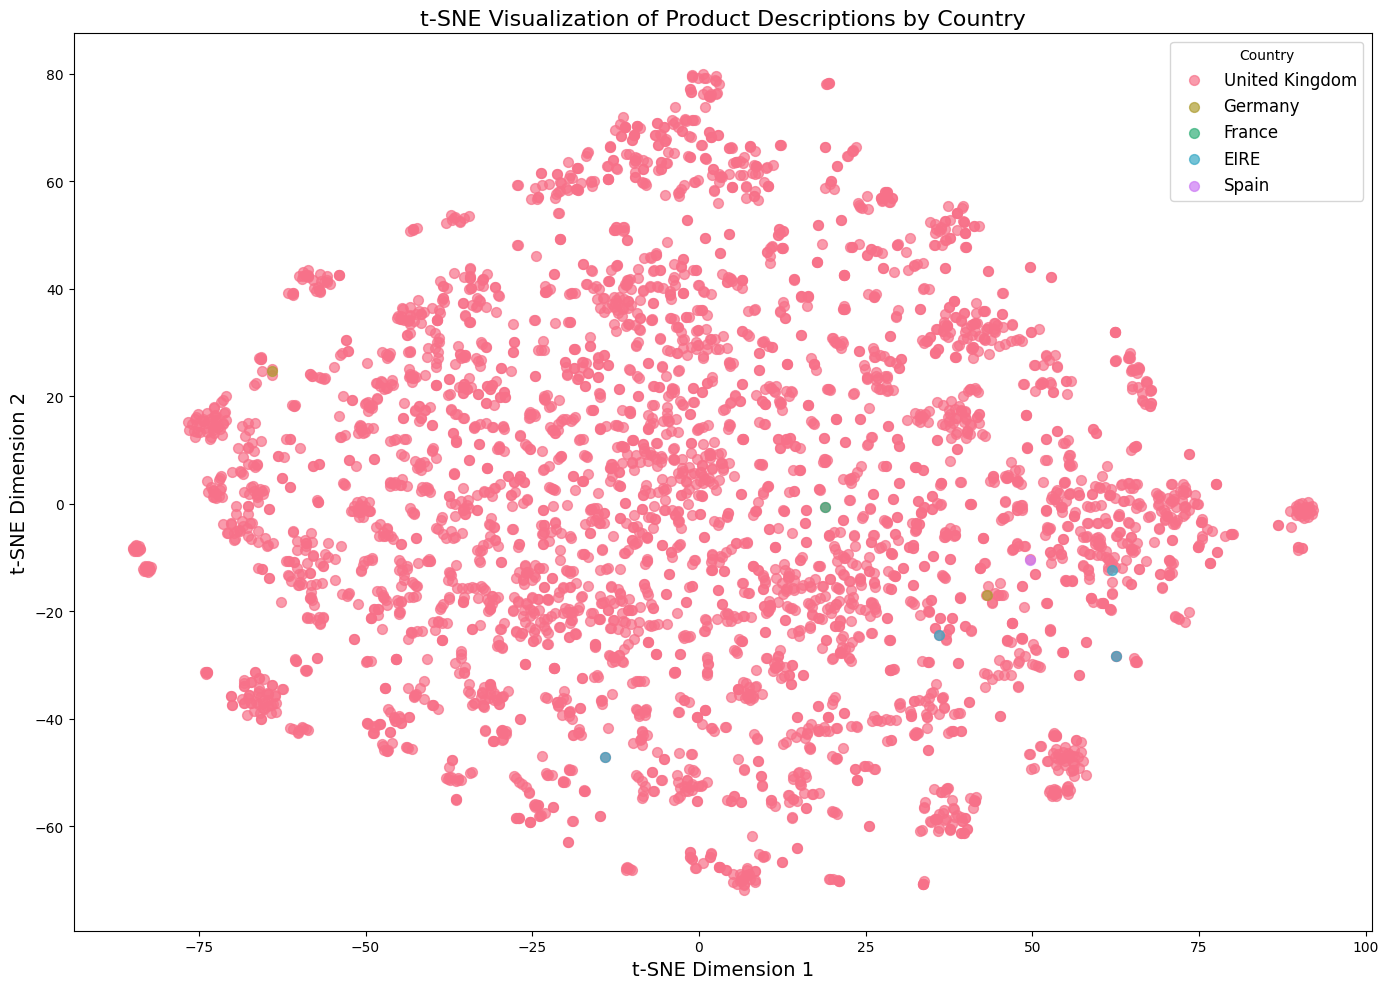

In [15]:
def create_tsne_plot(tsne_data, countries, country_list):
    """
    Create a t-SNE plot colored by country
    """
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'x': tsne_data[:, 0],
        'y': tsne_data[:, 1],
        'country': countries,
        'description': descriptions
    })
    
    # Set up the plot
    plt.figure(figsize=(14, 10))
    
    # Create a color palette for the top countries
    palette = sns.color_palette("husl", len(country_list))
    color_map = {country: color for country, color in zip(country_list, palette)}
    
    # Plot each country
    for country in country_list:
        subset = plot_df[plot_df['country'] == country]
        plt.scatter(subset['x'], subset['y'], 
                   label=country, 
                   color=color_map[country],
                   alpha=0.7, 
                   s=50)
    
    # Add some visual enhancements
    plt.title('t-SNE Visualization of Product Descriptions by Country', fontsize=16)
    plt.xlabel('t-SNE Dimension 1', fontsize=14)
    plt.ylabel('t-SNE Dimension 2', fontsize=14)
    plt.legend(title='Country', fontsize=12)
    plt.tight_layout()
    
    return plot_df

# Create the visualization
plot_df = create_tsne_plot(tsne_embeddings, countries, top_countries)